In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

In [5]:
pd.set_option('display.max_columns', None)

In [82]:
# Reading Train & Test datasets
df_train = pd.read_csv('./bigquery-geotab-intersection-congestion/train.csv')
print ("shape of train dataset :", df_train.shape)
df_train = df_train.dropna()
print ("shape of train dataset :", df_train.shape)

shape of train dataset : (856387, 28)
shape of train dataset : (842452, 28)


In [59]:

# display the first 5 observations of Train dataset
df_train.head()

shape of train dataset : (842452, 28)


,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,6,Marietta Boulevard Northwest_SE_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,6,Marietta Boulevard Northwest_SE_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


In [7]:
# TARGET COLUMNS
# TotalTimeStopped_p20	TotalTimeStopped_p40
# TotalTimeStopped_p50 TotalTimeStopped_p60
# TotalTimeStopped_p80	TimeFromFirstStop_p20
# TimeFromFirstStop_p40	TimeFromFirstStop_p50
# TimeFromFirstStop_p60 TimeFromFirstStop_p80
# DistanceToFirstStop_p20	DistanceToFirstStop_p40
# DistanceToFirstStop_p50	DistanceToFirstStop_p60
# DistanceToFirstStop_p80

df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [23]:
train_city = df_train.groupby('City').size().reset_index().rename(columns={0:'Count'})
# train_intersection = df_train.groupby('IntersectionId').size().reset_index().rename(columns={0:'count'})
train_intersection = df_train[['City', 'IntersectionId']].drop_duplicates().groupby('City').size().reset_index().rename(columns={0:'Num_intersections'})
train_months = df_train.groupby('Month').size().reset_index().rename(columns={0:'Count'})
train_hours = df_train.groupby('Hour').size().reset_index().rename(columns={0:'Count'})

print("Train City:\n", train_city)
print("\nTrain Intersecections:\n", train_intersection)
print("\nTrain Months (0 is Jan):\n", train_months)
print("\nTrain Hours:\n", train_hours)

Train City:
            City   Count
0       Atlanta  156484
1        Boston  178617
2       Chicago  131049
3  Philadelphia  390237

Train Intersecections:
            City  Num_intersections
0       Atlanta                377
1        Boston                975
2       Chicago               2135
3  Philadelphia               1318

Train Months (0 is Jan):
    Month   Count
0      1     825
1      5     175
2      6  109760
3      7  110750
4      8  122755
5      9  124686
6     10  133489
7     11  124739
8     12  129208

Train Hours:
     Hour  Count
0      0  26174
1      1  21845
2      2  17654
3      3  14172
4      4  13902
5      5  19949
6      6  30470
7      7  39789
8      8  46170
9      9  48928
10    10  50220
11    11  49863
12    12  48533
13    13  48378
14    14  48918
15    15  46898
16    16  43744
17    17  40465
18    18  37674
19    19  34771
20    20  33424
21    21  33093
22    22  31597
23    23  29756


In [24]:
df_train[['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
          'TotalTimeStopped_p60','TotalTimeStopped_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalTimeStopped_p20,856387.0,1.755596,7.146549,0.0,0.0,0.0,0.0,298.0
TotalTimeStopped_p40,856387.0,5.403592,12.981674,0.0,0.0,0.0,0.0,375.0
TotalTimeStopped_p50,856387.0,7.722655,15.685910,0.0,0.0,0.0,10.0,375.0
TotalTimeStopped_p60,856387.0,11.925195,19.761325,0.0,0.0,0.0,18.0,377.0
TotalTimeStopped_p80,856387.0,22.948621,28.274091,0.0,0.0,16.0,34.0,763.0


In [25]:
df_train[['TimeFromFirstStop_p20','TimeFromFirstStop_p40', 'TimeFromFirstStop_p50','TimeFromFirstStop_p60',
          'TimeFromFirstStop_p80']].describe().T


,count,mean,std,min,25%,50%,75%,max
TimeFromFirstStop_p20,856387.0,3.181096,11.835994,0.0,0.0,0.0,0.0,337.0
TimeFromFirstStop_p40,856387.0,9.162174,20.446568,0.0,0.0,0.0,0.0,356.0
TimeFromFirstStop_p50,856387.0,12.722165,24.219271,0.0,0.0,0.0,22.0,356.0
TimeFromFirstStop_p60,856387.0,18.926085,29.851797,0.0,0.0,0.0,31.0,357.0
TimeFromFirstStop_p80,856387.0,34.201656,41.130668,0.0,0.0,27.0,49.0,359.0


In [27]:
df_train[['DistanceToFirstStop_p20','DistanceToFirstStop_p40', 'DistanceToFirstStop_p50','DistanceToFirstStop_p60',
 'DistanceToFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
DistanceToFirstStop_p20,856387.0,6.765856,29.535968,0.0,0.0,0.0,0.00,1901.9
DistanceToFirstStop_p40,856387.0,20.285128,59.202108,0.0,0.0,0.0,0.00,2844.4
DistanceToFirstStop_p50,856387.0,28.837113,75.217343,0.0,0.0,0.0,53.10,2851.1
DistanceToFirstStop_p60,856387.0,44.272310,102.032250,0.0,0.0,0.0,64.20,3282.4
DistanceToFirstStop_p80,856387.0,83.991313,160.709797,0.0,0.0,60.4,85.95,4079.2


In [26]:
df_train.groupby('City').agg({'TotalTimeStopped_p80':'mean','TimeFromFirstStop_p80':'mean','DistanceToFirstStop_p80':'mean'})

,TotalTimeStopped_p80,TimeFromFirstStop_p80,DistanceToFirstStop_p80
City,,,
Atlanta,28.911256,41.621201,105.185034
Boston,25.922292,35.435076,62.671911
Chicago,21.380041,31.045220,69.869600
Philadelphia,19.723289,31.721877,89.993218


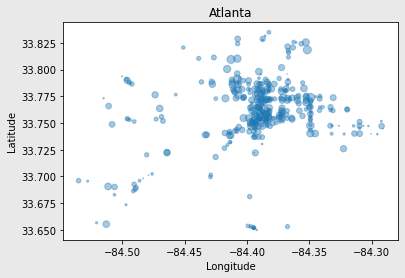

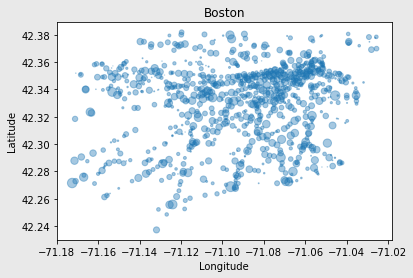

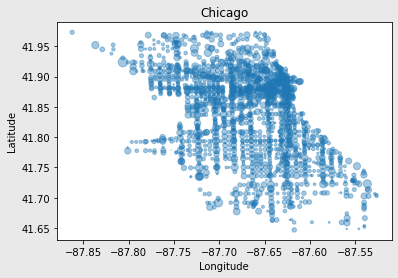

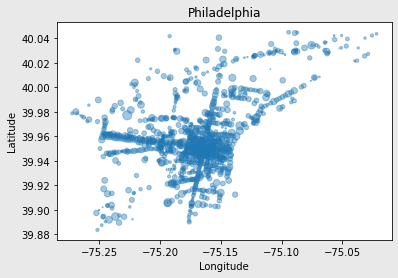

In [66]:
data = df_train.groupby(['City','IntersectionId','Latitude','Longitude']).agg({'TotalTimeStopped_p80':'mean'}).reset_index()

for city in data['City'].unique().tolist():
    y = data[data['City']==city]['Latitude']
    x = data[data['City']==city]['Longitude']
    sizes = data[data['City']==city]['TotalTimeStopped_p80']

    fig = plt.figure()

    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)

    plt.scatter(x, y, s=sizes, alpha=0.4)
    plt.title(city)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")


    plt.show()

In [83]:
print(df_train.head())

     RowId  IntersectionId   Latitude  Longitude  \
0  1921357               0  33.791659 -84.430032   
1  1921358               0  33.791659 -84.430032   
2  1921359               0  33.791659 -84.430032   
3  1921360               0  33.791659 -84.430032   
4  1921361               0  33.791659 -84.430032   

                EntryStreetName                ExitStreetName EntryHeading  \
0  Marietta Boulevard Northwest  Marietta Boulevard Northwest           NW   
1  Marietta Boulevard Northwest  Marietta Boulevard Northwest           SE   
2  Marietta Boulevard Northwest  Marietta Boulevard Northwest           NW   
3  Marietta Boulevard Northwest  Marietta Boulevard Northwest           SE   
4  Marietta Boulevard Northwest  Marietta Boulevard Northwest           NW   

  ExitHeading  Hour  Weekend  Month  \
0          NW     0        0      6   
1          SE     0        0      6   
2          NW     1        0      6   
3          SE     1        0      6   
4          NW     2    

In [154]:
# We create PCA and plot variance explained
numeric_cols = df_train.copy()
text_cols = ['EntryStreetName', 'ExitStreetName', 'EntryHeading',
             'ExitHeading', 'Path', 'City']
for col in text_cols:
    numeric_cols[col] = pd.factorize(numeric_cols[col])[0]
    #pd.Categorical(numeric_cols[col])
    # numeric_cols[col] = numeric_cols[col].astype(str)
# numeric_cols[text_cols] = numeric_cols[text_cols].apply(pd.to_numeric)

print(numeric_cols.shape)
# print(numeric_cols.head())
drop_cols = ['RowId', 'TotalTimeStopped_p20','TotalTimeStopped_p40',
'TotalTimeStopped_p50', 'TotalTimeStopped_p60',
'TotalTimeStopped_p80',	'TimeFromFirstStop_p20',
'TimeFromFirstStop_p40',	'TimeFromFirstStop_p50',
'TimeFromFirstStop_p60', 'TimeFromFirstStop_p80',
'DistanceToFirstStop_p20',	'DistanceToFirstStop_p40',
'DistanceToFirstStop_p50',	'DistanceToFirstStop_p60',
'DistanceToFirstStop_p80']
numeric_cols = numeric_cols.drop(drop_cols, axis=1)
test_drops = [ 'Path', "IntersectionId", "ExitStreetName", "EntryStreetName",
               'EntryHeading', 'ExitHeading', 'City']
numeric_cols = numeric_cols.drop(test_drops, axis=1)
numeric_cols.info()

(842452, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 842452 entries, 0 to 856386
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Latitude   842452 non-null  float64
 1   Longitude  842452 non-null  float64
 2   Hour       842452 non-null  int64  
 3   Weekend    842452 non-null  int64  
 4   Month      842452 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 70.8 MB


In [151]:
pca = PCA()
pca.fit_transform(numeric_cols.values)
print("Num Components:", range(pca.n_components_))
print("Len Variance:", len(pca.explained_variance_))
print("Explained Variance:", pca.explained_variance_)

Num Components: range(0, 8)
Len Variance: 8
Explained Variance: [38.08893696 36.96300278  7.07008639  6.1179302   3.9399518   1.57946493
  0.94113576  0.18637185]


In [137]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[706203.34611446 269913.49543261  16029.21861606]
[0.71173026 0.2720259  0.01615467]
[0.71173026 0.98375617 0.99991084]


[[-2.56734885e-01 -9.54545984e-01  8.18089904e-02  8.06132608e-02
   7.03613925e-02 -4.98035647e-03 -1.84078723e-02 -6.65099582e-02]
 [ 2.74589040e-03 -7.31974906e-02 -1.88083811e-04  1.41230081e-04
  -9.97103986e-01 -2.38576157e-03 -1.77386995e-02 -9.89037356e-03]
 [-7.18382400e-01  1.27552863e-01 -4.57998055e-01 -4.64395067e-01
  -9.78717481e-03  2.44024932e-02  2.33689980e-02 -2.02471275e-01]
 [ 6.13203672e-01 -2.55803352e-01 -5.24783274e-01 -5.27437893e-01
   2.05824343e-02 -3.09589055e-02 -2.98392665e-02  5.18190423e-02]
 [-3.23414861e-02  2.94709403e-02  3.74178843e-03  2.24362812e-03
   1.55103498e-02 -8.20277998e-03 -9.98875080e-01  2.67847880e-03]
 [-1.04891564e-03 -5.07095224e-04 -7.09688564e-01  7.04477287e-01
   3.56163114e-04  6.91159094e-04 -1.07638229e-03 -7.12559283e-03]
 [ 1.96411691e-01  2.67631679e-02  6.68990969e-02  5.79093803e-02
   8.52035487e-03 -6.86224278e-02 -7.10417484e-03 -9.73676071e-01]
 [ 4.86108972e-02 -1.39263280e-02  4.49980570e-04 -1.09278360e-03
  -

Text(0.5, 0, 'PCA feature')

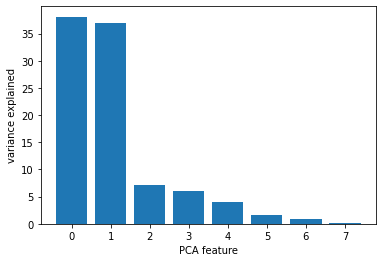

In [153]:
print(pca.components_)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.ylabel('variance explained')
plt.xlabel('PCA feature')


In [152]:
print(pd.DataFrame(pca.components_,columns=numeric_cols.columns))



   Latitude  Longitude  EntryHeading  ExitHeading      Hour   Weekend  \
0 -0.256735  -0.954546      0.081809     0.080613  0.070361 -0.004980   
1  0.002746  -0.073197     -0.000188     0.000141 -0.997104 -0.002386   
2 -0.718382   0.127553     -0.457998    -0.464395 -0.009787  0.024402   
3  0.613204  -0.255803     -0.524783    -0.527438  0.020582 -0.030959   
4 -0.032341   0.029471      0.003742     0.002244  0.015510 -0.008203   
5 -0.001049  -0.000507     -0.709689     0.704477  0.000356  0.000691   
6  0.196412   0.026763      0.066899     0.057909  0.008520 -0.068622   
7  0.048611  -0.013926      0.000450    -0.001093 -0.000442  0.996814   

      Month      City  
0 -0.018408 -0.066510  
1 -0.017739 -0.009890  
2  0.023369 -0.202471  
3 -0.029839  0.051819  
4 -0.998875  0.002678  
5 -0.001076 -0.007126  
6 -0.007104 -0.973676  
7 -0.010341 -0.060793  
